# HSI Classification: Local Similarity Analysis

This notebook demonstrates the hyperspectral image classification pipeline with focus on **Efficient local similarity**.

## Contents
1. Data Loading & Preprocessing
2. Patch Extraction
3. Similarity Metrics Exploration
4. Model Training with MLflow
5. Evaluation & Visualization

## 1. Setup & Imports

In [3]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Import our modules
from src.data import load_hsi, load_benchmark_dataset, preprocess_pipeline
from src.features import extract_patches, split_dataset
from src.models import (
    rbf_similarity, sam_similarity, local_similarity_matrix,
    SVMClassifier, create_model, train_svm, train_neural_network,
    compute_all_metrics, print_classification_report
)

# MLflow
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")

print("✓ All imports successful!")

✓ All imports successful!


## 2. Generate Synthetic Data (for testing)

Replace this with actual HSI data loading in practice.

In [4]:
USE_REAL_DATA = True  # Set to True if Indian Pines is downloaded

project_root = Path.cwd().parent 

# Construct the absolute path to the data
DATA_DIR = project_root / 'data' / 'external' / 'indian_pines'

if USE_REAL_DATA:
    from src.data import load_benchmark_dataset
    # Pass the absolute path instead of a relative string
    cube = load_benchmark_dataset('indian_pines', DATA_DIR)
    hsi_data = cube.data
    ground_truth = cube.ground_truth
    class_names = cube.class_names

else : 
    np.random.seed(42)
    
    # Dimensions
    height, width, n_bands = 100, 100, 200
    n_classes = 5
    
    # Create class-specific spectral signatures
    class_spectra = np.random.randn(n_classes, n_bands)
    
    # Generate ground truth
    ground_truth = np.zeros((height, width), dtype=np.int32)
    for c in range(n_classes):
        mask = np.random.random((height, width)) < (1 / n_classes)
        ground_truth[mask] = c
    
    # Generate HSI cube based on ground truth
    hsi_cube = np.zeros((height, width, n_bands), dtype=np.float32)
    for c in range(n_classes):
        mask = ground_truth == c
        hsi_data[mask] = class_spectra[c] + 0.1 * np.random.randn(np.sum(mask), n_bands)

print(f"HSI Cube shape: {hsi_data.shape}")
print(f"Ground Truth shape: {ground_truth.shape}")
print(f"Classes: {np.unique(ground_truth)}")

/Users/ashutoshbaruah/Documents/dev/THESIS-HSI-Classification/data/external/indian_pines/Indian_pines_corrected.mat
Filepath : /Users/ashutoshbaruah/Documents/dev/THESIS-HSI-Classification/data/external/indian_pines/Indian_pines_corrected.mat
HSI Cube shape: (145, 145, 200)
Ground Truth shape: (145, 145)
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


## 3. Preprocessing

In [6]:
# Apply preprocessing pipeline
result = preprocess_pipeline(
    hsi_data,
    remove_water=False,  # No water bands in synthetic data
    reduce_dims='pca',
    n_components=30,
    normalize='minmax',
    log_to_mlflow=False
)

processed_data = result['data']
print(f"Processed shape: {processed_data.shape}")

Processed shape: (145, 145, 30)


## 4. Patch Extraction

In [7]:
# Extract patches
window_size = 5
dataset = extract_patches(
    processed_data,
    ground_truth,
    window_size=window_size,
    include_background=False,
    log_to_mlflow=False
)

print(f"Patches shape: {dataset.patches.shape}")
print(f"Number of samples: {dataset.n_samples}")

# Split into train/val/test
train_set, val_set, test_set = split_dataset(
    dataset,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    stratify=True,
    log_to_mlflow=False
)

print(f"Train: {train_set.n_samples}, Val: {val_set.n_samples}, Test: {test_set.n_samples}")

Patches shape: (10249, 5, 5, 30)
Number of samples: 10249
Train: 6149, Val: 2050, Test: 2050


## 5. Local Similarity Analysis

This is the core of the thesis research.

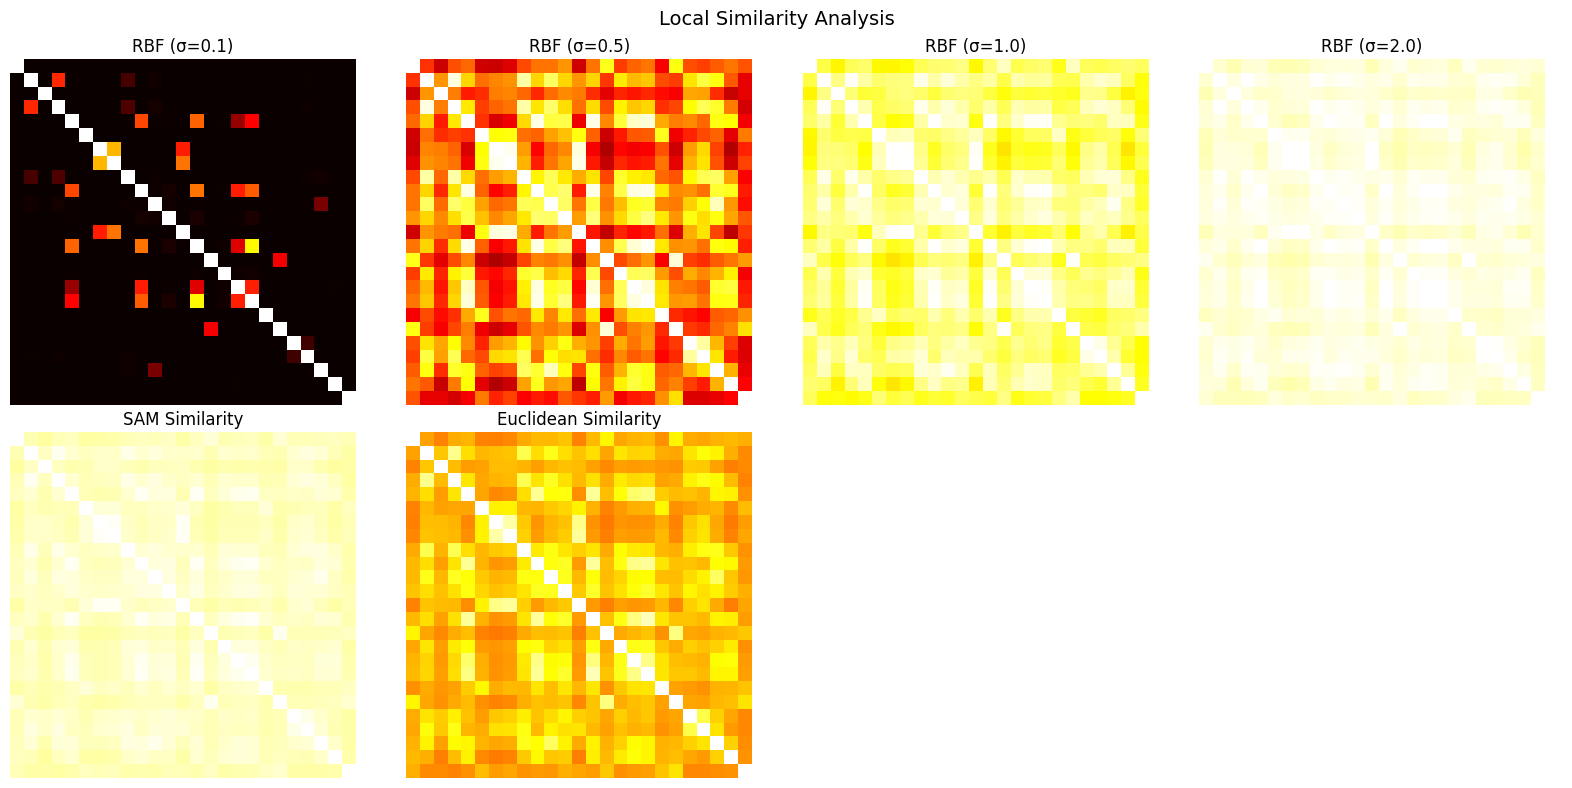

In [8]:
# Analyze local similarity for a sample patch
sample_patch = train_set.patches[0]

# Different similarity metrics
sigmas = [0.1, 0.5, 1.0, 2.0]

fig, axes = plt.subplots(2, len(sigmas), figsize=(16, 8))

# RBF similarity with different sigma values
for i, sigma in enumerate(sigmas):
    sim_matrix = local_similarity_matrix(sample_patch, metric='rbf', sigma=sigma)
    
    axes[0, i].imshow(sim_matrix, cmap='hot', vmin=0, vmax=1)
    axes[0, i].set_title(f'RBF (σ={sigma})')
    axes[0, i].axis('off')

# SAM vs Euclidean
sim_sam = local_similarity_matrix(sample_patch, metric='sam')
sim_euc = local_similarity_matrix(sample_patch, metric='euclidean')

axes[1, 0].imshow(sim_sam, cmap='hot', vmin=0, vmax=1)
axes[1, 0].set_title('SAM Similarity')
axes[1, 0].axis('off')

axes[1, 1].imshow(sim_euc, cmap='hot', vmin=0, vmax=1)
axes[1, 1].set_title('Euclidean Similarity')
axes[1, 1].axis('off')

# Hide unused axes
for j in range(2, len(sigmas)):
    axes[1, j].axis('off')

plt.suptitle('Local Similarity Analysis', fontsize=14)
plt.tight_layout()
plt.show()

## 6. SVM Classification

In [9]:
# Prepare flattened features for SVM
X_train = train_set.get_center_pixels()
y_train = train_set.labels

X_val = val_set.get_center_pixels()
y_val = val_set.labels

X_test = test_set.get_center_pixels()
y_test = test_set.labels

print(f"X_train shape: {X_train.shape}")

# Train SVM with RBF kernel (relates to RBF similarity in thesis)
svm = train_svm(
    X_train, y_train,
    X_val, y_val,
    kernel='rbf',
    C=10.0,
    gamma='scale',
    experiment_name='hsi_classification',
    run_name='SVM_RBF_baseline',
    log_to_mlflow=True
)

# Evaluate on test set
y_pred = svm.predict(X_test)
print_classification_report(y_test, y_pred)

X_train shape: (6149, 30)


2026/02/24 17:44:09 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/24 17:44:09 INFO mlflow.store.db.utils: Updating database tables
2026/02/24 17:44:10 INFO mlflow.tracking.fluent: Experiment with name 'hsi_classification' does not exist. Creating a new experiment.
2026/02/24 17:44:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/24 17:44:14 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html
2026/02/24 17:44:17 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


CLASSIFICATION REPORT
Overall Accuracy (OA):    0.8307
Average Accuracy (AA):    0.7979
Kappa Coefficient:        0.8065

------------------------------------------------------------
Per-Class Accuracy:
------------------------------------------------------------
  1                              0.6667
  2                              0.8070
  3                              0.6928
  4                              0.3958
  5                              0.9485
  6                              0.9726
  7                              1.0000
  8                              1.0000
  9                              0.5000
  10                             0.7692
  11                             0.8391
  12                             0.7458
  13                             0.9756
  14                             0.9605
  15                             0.5974
  16                             0.8947

------------------------------------------------------------
Per-Class Statistics:
------------

'============================================================\nCLASSIFICATION REPORT\n============================================================\nOverall Accuracy (OA):    0.8307\nAverage Accuracy (AA):    0.7979\nKappa Coefficient:        0.8065\n\n------------------------------------------------------------\nPer-Class Accuracy:\n------------------------------------------------------------\n  1                              0.6667\n  2                              0.8070\n  3                              0.6928\n  4                              0.3958\n  5                              0.9485\n  6                              0.9726\n  7                              1.0000\n  8                              1.0000\n  9                              0.5000\n  10                             0.7692\n  11                             0.8391\n  12                             0.7458\n  13                             0.9756\n  14                             0.9605\n  15                         

## 7. Neural Network Classification

In [10]:
import torch
from src.models import create_model, train_neural_network, create_data_loaders, TrainingConfig

# Get dimensions
n_bands = train_set.patches.shape[-1]
n_classes_nn = len(np.unique(train_set.labels))

# Create 3D-CNN model
model = create_model(
    model_type='3d_cnn',
    n_bands=n_bands,
    n_classes=n_classes_nn,
    patch_size=window_size
)
print(model)

# Create data loaders
train_loader = create_data_loaders(train_set.patches, train_set.labels, batch_size=32, data_format='3d')
val_loader = create_data_loaders(val_set.patches, val_set.labels, batch_size=32, shuffle=False, data_format='3d')

# Training config
config = TrainingConfig(
    experiment_name='hsi_classification',
    run_name='3D_CNN_experiment',
    n_epochs=20,
    batch_size=32,
    learning_rate=0.001,
    patience=10
)

# Train (set log_to_mlflow=True to track with MLflow)
model, history = train_neural_network(
    model, train_loader, val_loader,
    config=config,
    similarity_config={'metric': 'patch_based', 'window_size': window_size},
    log_to_mlflow=True
)

SpatialSpectralCNN3D(
  (features): Sequential(
    (0): Conv3d(1, 32, kernel_size=(7, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(32, 64, kernel_size=(5, 3, 3), stride=(1, 1, 1), padding=(2, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv3d(64, 128, kernel_size=(5, 3, 3), stride=(1, 1, 1), padding=(2, 1, 1))
    (7): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (gap): AdaptiveAvgPool3d(output_size=1)
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=16, bias=True)
  )
)


IndexError: Target 16 is out of bounds.

## 8. Visualization

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()

axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()